In [1]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot


In [2]:
#load all data
dataset = read_csv("household_power_consumption.txt", sep=";", header=0, low_memory=False,
infer_datetime_format=True, parse_dates={"datetime":[0,1]}, index_col=["datetime"])
#summarize
print(dataset.shape)
print(dataset.head())

(2075259, 7)
                    Global_active_power  ... Sub_metering_3
datetime                                 ...               
2006-12-16 17:24:00               4.216  ...           17.0
2006-12-16 17:25:00               5.360  ...           16.0
2006-12-16 17:26:00               5.374  ...           17.0
2006-12-16 17:27:00               5.388  ...           17.0
2006-12-16 17:28:00               3.666  ...           17.0

[5 rows x 7 columns]


In [3]:
#mark all missing values
dataset.replace("?", float("NaN"), inplace=True)

In [4]:
values = dataset.values.astype("float32")
global_act_pwr = values[:,0]
sub_metering_1 = values[:,-3]
sub_metering_2 = values[:,-2]
sub_metering_3 = values[:,-1]

#add column for sub-metering 4
dataset["Sub_metering_4"] = (global_act_pwr * 1000/60) - (sub_metering_1 + sub_metering_2 + sub_metering_3)
dataset

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0,71.800003
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0,43.099998
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0,15.766666
2010-11-26 20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0,15.733334
2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0,15.633333


In [5]:
#save updated dataset
dataset.to_csv("household_power_consumption.csv")

#summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True,
  parse_dates=['datetime'], index_col=['datetime'])
print(dataset.head())

                     Global_active_power  ...  Sub_metering_4
datetime                                  ...                
2006-12-16 17:24:00                4.216  ...       52.266670
2006-12-16 17:25:00                5.360  ...       72.333336
2006-12-16 17:26:00                5.374  ...       70.566666
2006-12-16 17:27:00                5.388  ...       71.800000
2006-12-16 17:28:00                3.666  ...       43.100000

[5 rows x 8 columns]


In [6]:
#downsample per-minute to daily total
daily_groups = dataset.resample("D")
daily_data = daily_groups.sum()

#summarize
print(daily_data.shape)
print(daily_data.head())
#save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  ...  Sub_metering_4
datetime                         ...                
2006-12-16             1209.176  ...    14680.933319
2006-12-17             3390.460  ...    36946.666732
2006-12-18             2203.826  ...    19028.433281
2006-12-19             1666.194  ...    13131.900043
2006-12-20             2225.748  ...    20384.800011

[5 rows x 8 columns]


In [7]:
#implement Root Mean Squared Error as error metric
def evaluate_forecasts(actual, predicted):
  scores = list()

  for i in range(actual.shape[1]):
    mse = mean_squared_error(actual[:,i], predicted[:,i])
    rmse = sqrt(mse)
    scores.append(rmse)

  s = 0
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s += (actual[row, col] - predicted[row, col]) ** 2
  
  overall_score = sqrt(s / (actual.shape[0] * actual.shape[1]))

  return overall_score, scores

In [8]:
def split_dataset(data):
  train = data[1: -328]
  test = data[-328: -6]

  #split into weekly data
  train = array(split(train, len(train)/7))
  test = array(split(test, len(test)/7))

  return train, test

In [9]:
dataset = read_csv('household_power_consumption_days.csv', header=0,
  infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

train, test = split_dataset(dataset.values)

# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1308.8359999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


In [10]:
def evaluate_model(func, train, test):
  history = [x for x in train]
  predictions = list()

  for i in range(len(test)):
    yhat_seq = func(history)
    predictions.append(yhat_seq)
    history.append(test[i,:])

  predictions = array(predictions)
  overall_score, scores = evaluate_forecasts(test[:, :, 0], predictions)

  return overall_score, scores

In [11]:
def summarize_scores(name, score, scores):
  s_scores = ', '.join(['%.1f' % s for s in scores])
  print('%s: [%.3f] %s' % (name, score, s_scores))

In [12]:
def daily_persistence(history):
  last_week = history[-1]
  value = last_week[-1, 0]
  forecast = [value for _ in range(7)]

  return forecast

In [13]:
def weekly_persistence(history):
  last_week = history[-1]
  return last_week[:, 0]

In [14]:
# week one year ago persistence model
def week_one_year_ago_persistence(history):
  # get the data for the prior week
  last_week = history[-52]
  return last_week[:, 0]

In [15]:
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)

In [16]:
# define the names and functions for the models we wish to evaluate
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence

daily: [638.933] 467.4, 642.0, 607.9, 706.1, 658.6, 629.6, 727.2
weekly: [605.523] 704.6, 611.7, 496.3, 647.0, 550.1, 446.9, 727.2
week-oya: [543.820] 657.5, 490.2, 430.0, 565.0, 477.0, 357.1, 733.8


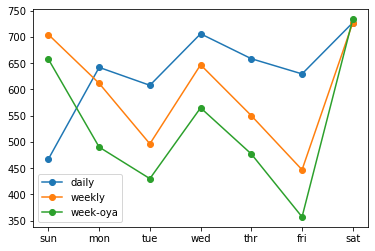

In [24]:
#evaluate each model
days = ["sun", "mon", "tue", "wed", "thr", "fri", "sat"]

for name, func in models.items():
  score, scores = evaluate_model(func, train, test)
  # summarize scores
  summarize_scores(name, score, scores)
  # plot scores
  pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.savefig("naive_forecasts.png")
